
 Processing: Test_Image_1.jpg

Detected Text: PUSH


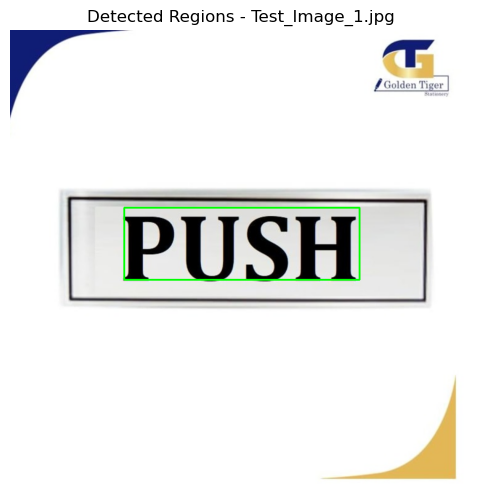


 Processing: Test_Image_2.jpg

Detected Text: EXIT SIGN STEALERS 03 wal


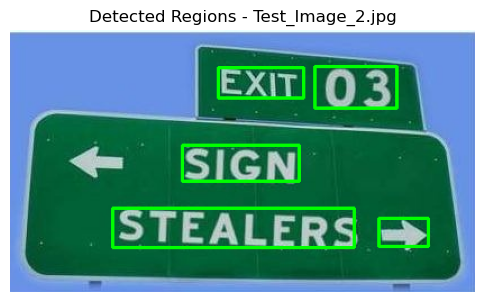


 Processing: Test_Image.jpg

Detected Text: STOP


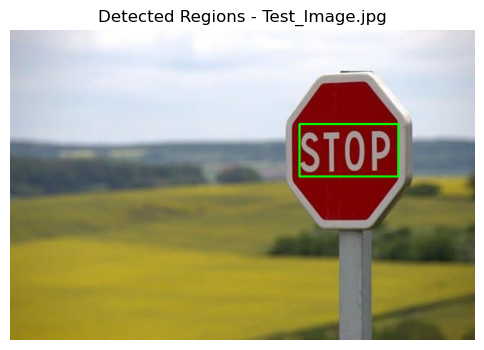

In [26]:
import cv2, numpy as np, pytesseract, matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression
# Tesseract path (Windows only – change if needed)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
# Load EAST deep neural network model
east_model_path = "frozen_east_text_detection.pb"
net = cv2.dnn.readNet(east_model_path)
# List of images to test
image_list = ["Test_Image_1.jpg", "Test_Image_2.jpg", "Test_Image.jpg"]
# ================= Decode Function (Required for DNN Output) ================= #
def decode_predictions(scores, geometry, confThreshold=0.5):
    (numRows, numCols) = scores.shape[2:4]
    rects, confidences = [], []
    for y in range(numRows):
        scoresData = scores[0, 0, y]
        x0, x1, x2, x3, angles = [geometry[0, i, y] for i in range(5)]
        for x in range(numCols):
            if scoresData[x] < confThreshold:
                continue
            offsetX, offsetY = x * 4.0, y * 4.0
            angle = angles[x]
            cos, sin = np.cos(angle), np.sin(angle)
            h = x0[x] + x2[x]
            w = x1[x] + x3[x]
            endX = int(offsetX + cos * x1[x] + sin * x2[x])
            endY = int(offsetY - sin * x1[x] + cos * x2[x])
            startX, startY = int(endX - w), int(endY - h)
            rects.append((startX, startY, endX, endY))
            confidences.append(float(scoresData[x]))
    return rects, confidences
# ======================= PROCESS MULTIPLE IMAGES ======================= #
for img in image_list:
    print("\n==============================")
    print(" Processing:", img)
    print("==============================\n")
    image = cv2.imread(img)
    orig = image.copy()
    (H, W) = image.shape[:2]
    newW = newH = 320
    rW, rH = W / newW, H / newH
    # DNN Forward pass
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (newW, newH)), 1.0, (newW, newH),
                                 (123.68,116.78,103.94), swapRB=True, crop=False)
    net.setInput(blob)
    scores, geometry = net.forward([
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"
    ])
    # Decode & perform non-max suppression
    rects, confidences = decode_predictions(scores, geometry, 0.5)
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    full_text = ""
    for (startX, startY, endX, endY) in boxes:
        startX = max(0, int(startX * rW))
        startY = max(0, int(startY * rH))
        endX   = min(W - 1, int(endX * rW))
        endY   = min(H - 1, int(endY * rH))
        roi = orig[startY:endY, startX:endX]
        if roi.size == 0: 
            continue
        text = pytesseract.image_to_string(roi, config="--psm 7").strip()
        if text:
            full_text += text + " "
            cv2.rectangle(orig,(startX,startY),(endX,endY),(0,255,0),2)
    print("Detected Text:", full_text.strip())
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Detected Regions - " + img)
    plt.show()